## Начало лабораторной работы

*Вариант 3:* Диабет у индейцев Пима 

#### Перечислим атрибуты датасета

Pregnancies — Количество беременностей.

Glucose — Уровень глюкозы в крови.

BloodPressure — Диастолическое артериальное давление.

SkinThickness — Толщина кожной складки на трицепсе.

Insulin — Уровень инсулина в сыворотке крови.

BMI — Индекс массы тела.

DiabetesPedigreeFunction — Функция родословной диабета.

Age — Возраст.

Outcome — Наличие диабета (0 — нет, 1 — да).

Группировать индейцев Пима по "интересным" характеристикам для анализа и информирования: Риск развития диабета (на основе уровня глюкозы, BMI и DiabetesPedigreeFunction); Возрастные группы с высокой заболеваемостью (например, молодёжь и пожилые); Факторы риска у женщин с беременностями (Pregnancies, Insulin, и SkinThickness); Уровень давления и инсулина у людей с подтверждённым диабетом.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv("C:/Users/TIGR228/Desktop/МИИ/Lab1/AIM-PIbd-31-Afanasev-S-S/static/csv/diabetes.csv")
df = df.head(1500)
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


#### Очистка данных

Удалим несущественные данные

In [2]:
df_cleaned = df.drop(columns=['SkinThickness', 'Insulin'], errors='ignore').dropna()
print(df_cleaned.head())  # Вывод очищенного DataFrame

   Pregnancies  Glucose  BloodPressure   BMI  DiabetesPedigreeFunction  Age  \
0            6      148             72  33.6                     0.627   50   
1            1       85             66  26.6                     0.351   31   
2            8      183             64  23.3                     0.672   32   
3            1       89             66  28.1                     0.167   21   
4            0      137             40  43.1                     2.288   33   

   Outcome  
0        1  
1        0  
2        1  
3        0  
4        1  


#### Визуализация парных взаимосвязей

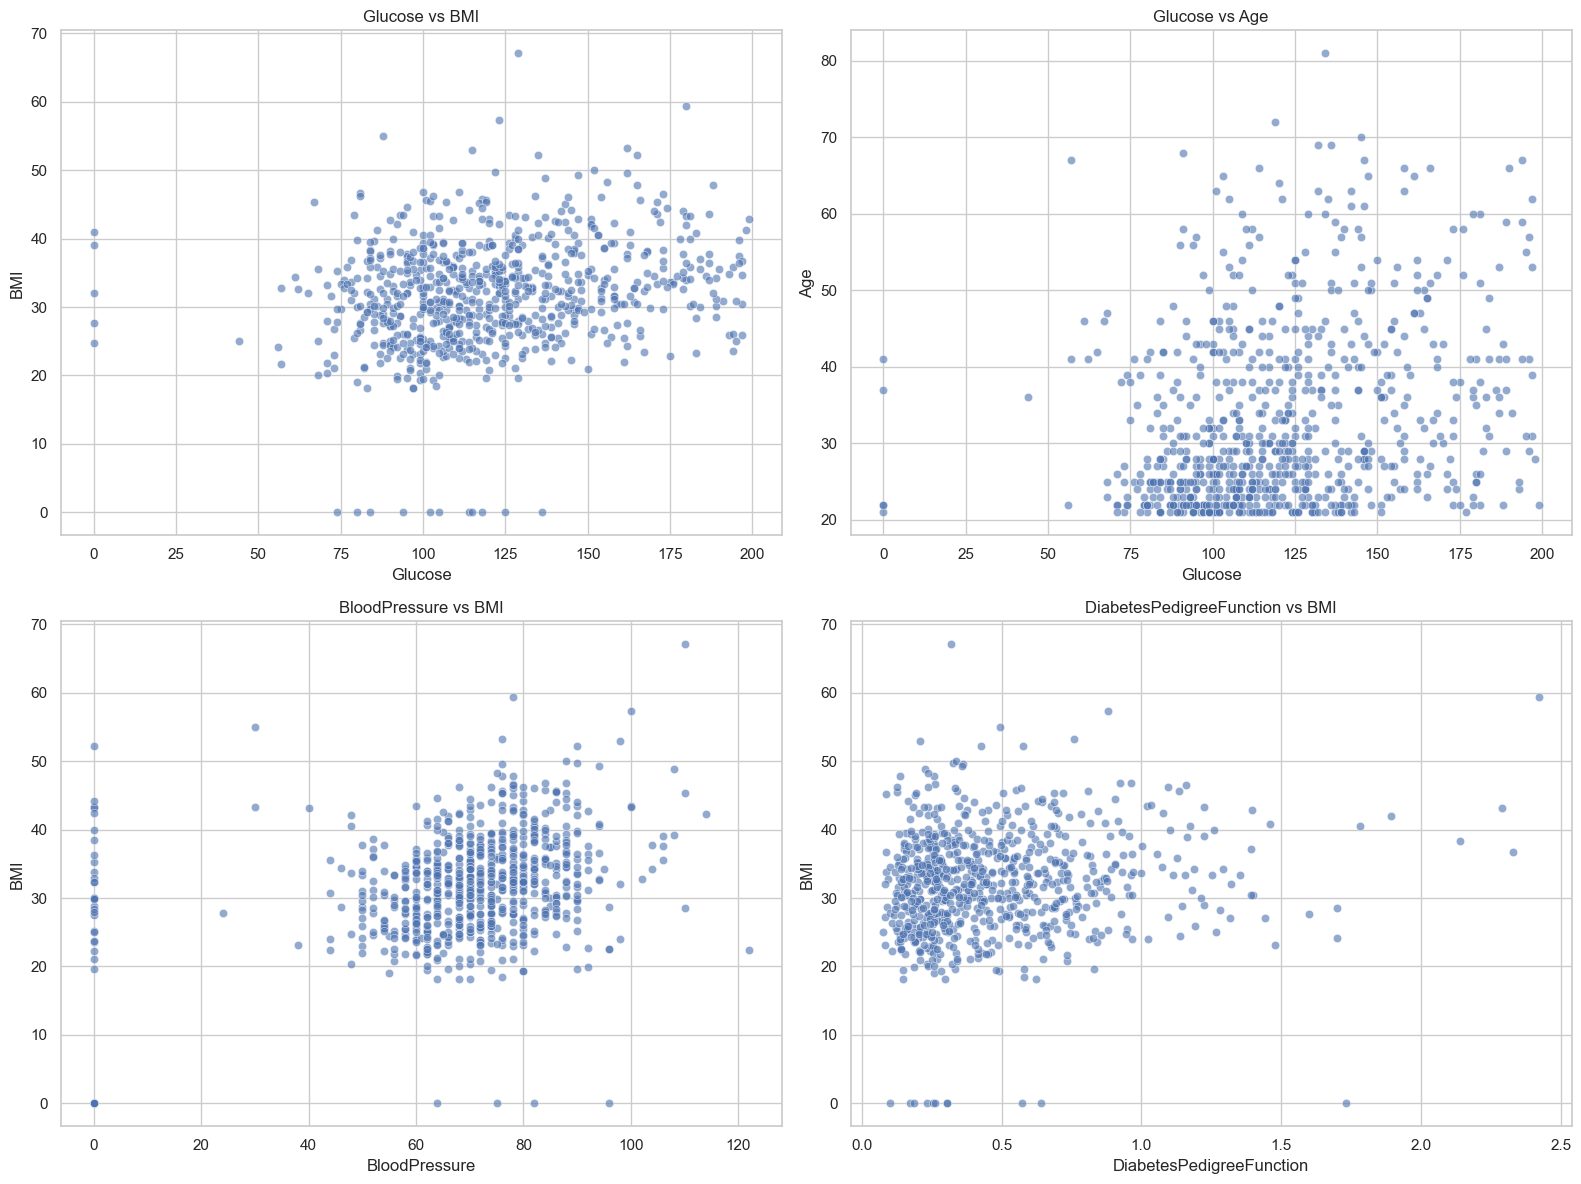

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(16, 12))

# Визуализация взаимосвязи уровня глюкозы и индекса массы тела
plt.subplot(2, 2, 1)
sns.scatterplot(x=df_cleaned['Glucose'], y=df_cleaned['BMI'], alpha=0.6)
plt.title('Glucose vs BMI')

# Визуализация взаимосвязи уровня глюкозы и возраста
plt.subplot(2, 2, 2)
sns.scatterplot(x=df_cleaned['Glucose'], y=df_cleaned['Age'], alpha=0.6)
plt.title('Glucose vs Age')

# Визуализация взаимосвязи артериального давления и индекса массы тела
plt.subplot(2, 2, 3)
sns.scatterplot(x=df_cleaned['BloodPressure'], y=df_cleaned['BMI'], alpha=0.6)
plt.title('BloodPressure vs BMI')

# Визуализация взаимосвязи DiabetesPedigreeFunction и индекса массы тела
plt.subplot(2, 2, 4)
sns.scatterplot(x=df_cleaned['DiabetesPedigreeFunction'], y=df_cleaned['BMI'], alpha=0.6)
plt.title('DiabetesPedigreeFunction vs BMI')

plt.tight_layout()
plt.show()


#### Стандартизация данных для кластеризации

Стандартизация данных — процесс приведения всех признаков (столбцов) к одному масштабу.

In [4]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cleaned)

#### Агломеративная (иерархическая) кластеризация

Иерархическая кластеризация — метод машинного обучения, предназначенный для группировки объектов (точек данных) на основе их схожести или расстояния друг от друга. Основная идея заключается в создании структуры кластеров в виде дерева (дендрограммы), которое показывает, как объекты группируются на разных уровнях.

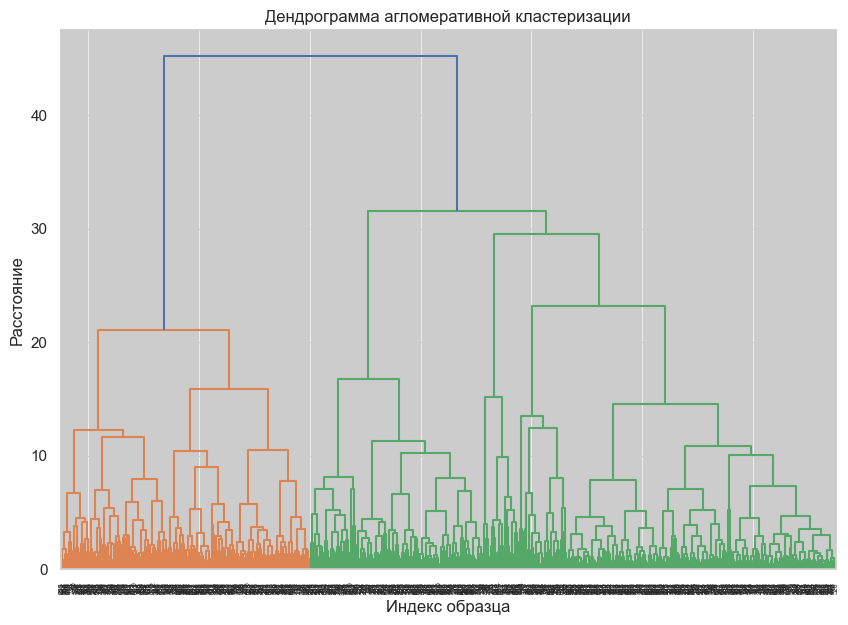

[ 3 20  3 20 14 11  6 13  1  8 11  2 16  1  1 13  5  7 13  6 16  8  2  7
  2  7  7 20  8 11  8  4 20 11  8 15 10  3  6  3  9 16  8  2  9 14 18 18
  6 12 18 20 20  1  9 20  2 16 16 17 12  7 20 18  7 11  4 16 20  9  6  9
  2 17 17 19 11 20 13 20 20 12 11 20  2 18 10 17  2 20 20  9 10  1 18 10
 20 20 20  5  4 18 18 20 17 18 18  9 20  5  5  3 20 20  3  1  7 20 20 11
  5 17 17  8  6 13 17 20  7  1  5  3  5 11 18 17 18 18 18 17  8 11 20  7
  9 15 10 15  8 20 17  9  3 16  2  2 20 15 20  2  9 10 17 20  4  3  9  9
 20 18  7  6 13 17 20  3 11  5 10  3 11 17 19 20  9  3  1  4  3  6 20 10
  3 13 11  5 20  6  6  6 18 17 18 20  8 11  1  2 18  2 20 17  8  5  7  2
  6  9  3  7  4  1 13  8 18 17 17  5 14 17  5  2 18 17 20  5  1  5  3 18
 20 20  6  3 17  3 10  5 10 17 11 17 18 17  3  6 20 20  9  3  9 13 18  8
  6 11 13 16 20 13  2 20  9 17 10 17  7 18  8 15  5 10 10  1  7  8 16  5
 20 17 17  6  4  5  8  9  6 18  7  8 13  6 11  2  9 17  1 18  4  6 11 17
  6 20  3 17 20  5 17  1  9  6  6  3 17 18  6 10  5

In [5]:
linkage_matrix = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Дендрограмма агломеративной кластеризации')
plt.xlabel('Индекс образца')
plt.ylabel('Расстояние')
plt.show()

# Получение результатов кластеризации с заданным порогом
result = fcluster(linkage_matrix, t=10, criterion='distance')
print(result)  # Вывод результатов кластеризации

#### Визуализация распределения кластеров

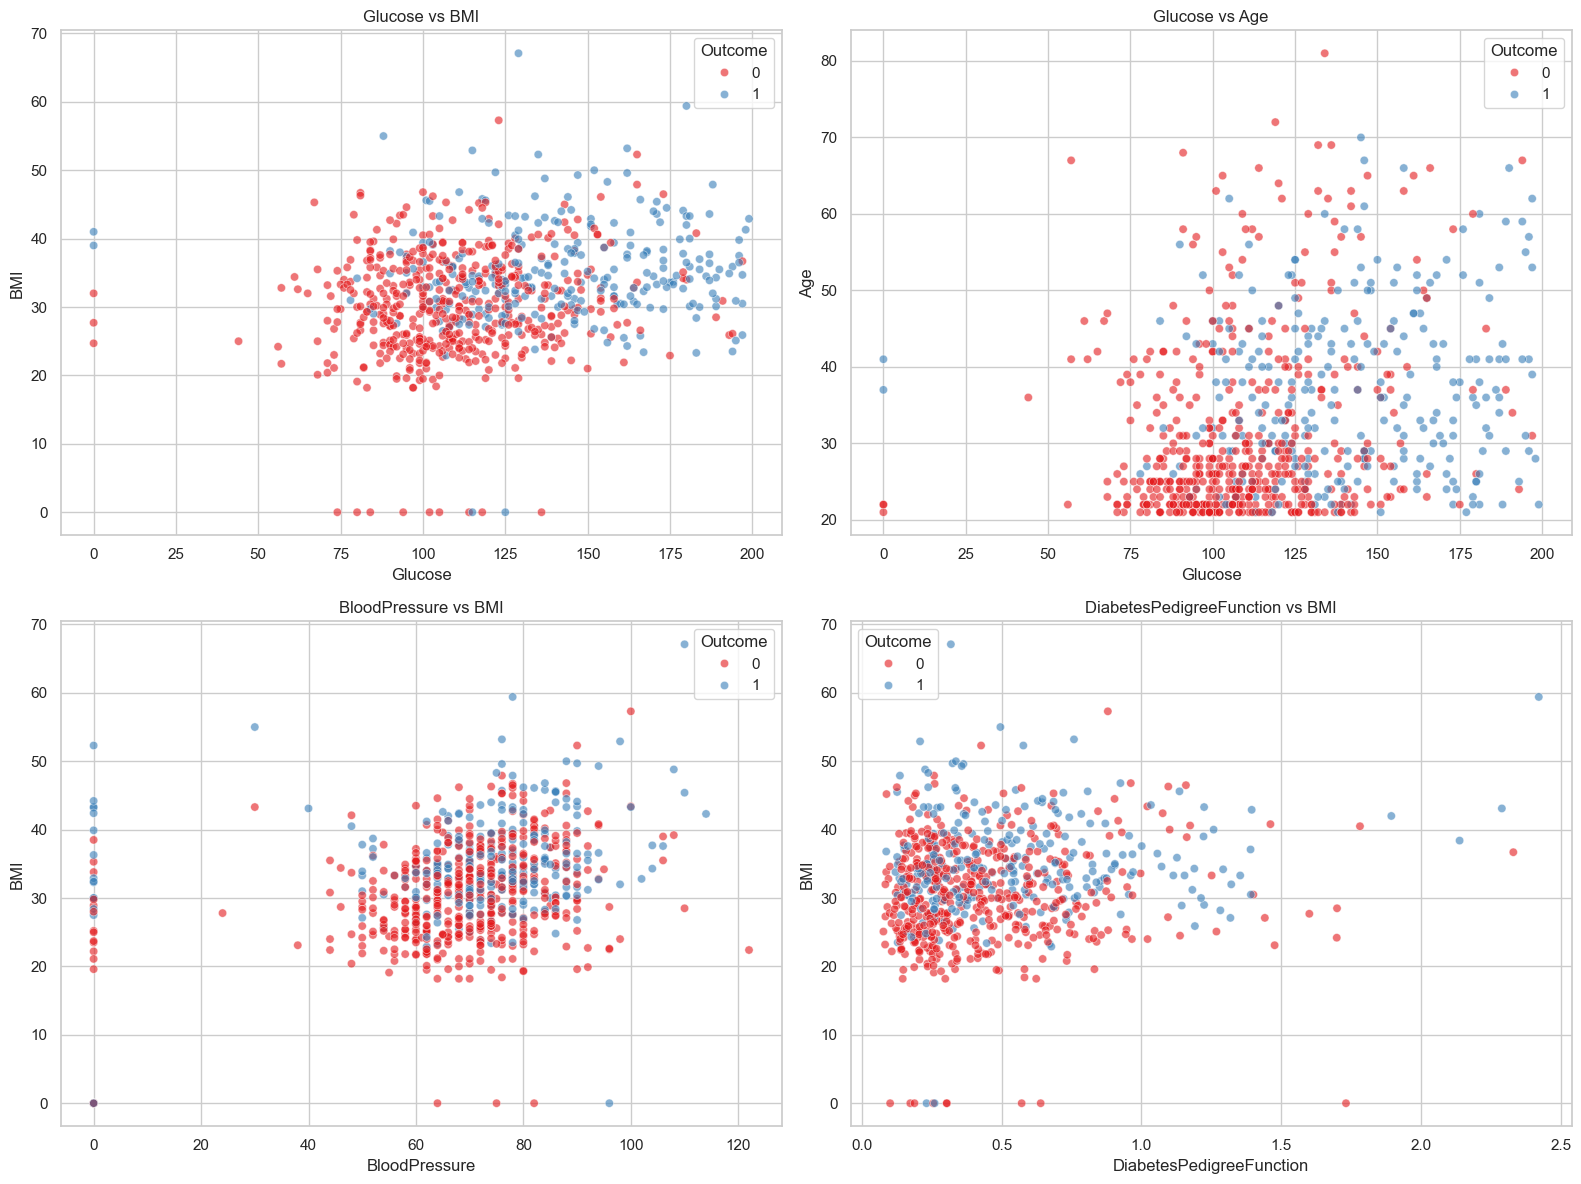

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(16, 12))

# Визуализация взаимосвязи уровня глюкозы и индекса массы тела
plt.subplot(2, 2, 1)
sns.scatterplot(x=df_cleaned['Glucose'], y=df_cleaned['BMI'], hue=df_cleaned['Outcome'], palette='Set1', alpha=0.6)
plt.title('Glucose vs BMI')

# Визуализация взаимосвязи уровня глюкозы и возраста
plt.subplot(2, 2, 2)
sns.scatterplot(x=df_cleaned['Glucose'], y=df_cleaned['Age'], hue=df_cleaned['Outcome'], palette='Set1', alpha=0.6)
plt.title('Glucose vs Age')

# Визуализация взаимосвязи артериального давления и индекса массы тела
plt.subplot(2, 2, 3)
sns.scatterplot(x=df_cleaned['BloodPressure'], y=df_cleaned['BMI'], hue=df_cleaned['Outcome'], palette='Set1', alpha=0.6)
plt.title('BloodPressure vs BMI')

# Визуализация взаимосвязи DiabetesPedigreeFunction и индекса массы тела
plt.subplot(2, 2, 4)
sns.scatterplot(x=df_cleaned['DiabetesPedigreeFunction'], y=df_cleaned['BMI'], hue=df_cleaned['Outcome'], palette='Set1', alpha=0.6)
plt.title('DiabetesPedigreeFunction vs BMI')

plt.tight_layout()
plt.show()


#### KMeans (неиерархическая кластеризация) для сравнения

Неиерархическая кластеризация — метод группировки данных, при котором объекты распределяются по заданному числу кластеров(в нашем случае - 
𝑘 в методе K-Means), основываясь на определенных метриках расстояния или схожести. В отличие от иерархической кластеризации, которая создает древовидную структуру кластеров, неиерархическая работает с фиксированным количеством кластеров и напрямую распределяет объекты в группы.

K-Means:
* Один из самых популярных методов.
* Делит данные на 𝑘 кластеров, минимизируя сумму квадратов расстояний от каждой точки до её центроида.
* Центроиды обновляются итеративно, пока результат не стабилизируется.

Центры кластеров:
 [[103.03726708  33.13167702  72.86335404  29.18322981]
 [105.31168831  25.04350649  45.6038961   25.57792208]
 [136.91472868  29.89457364  78.20155039  53.64341085]
 [158.21472393  37.96809816  76.68711656  32.34969325]]


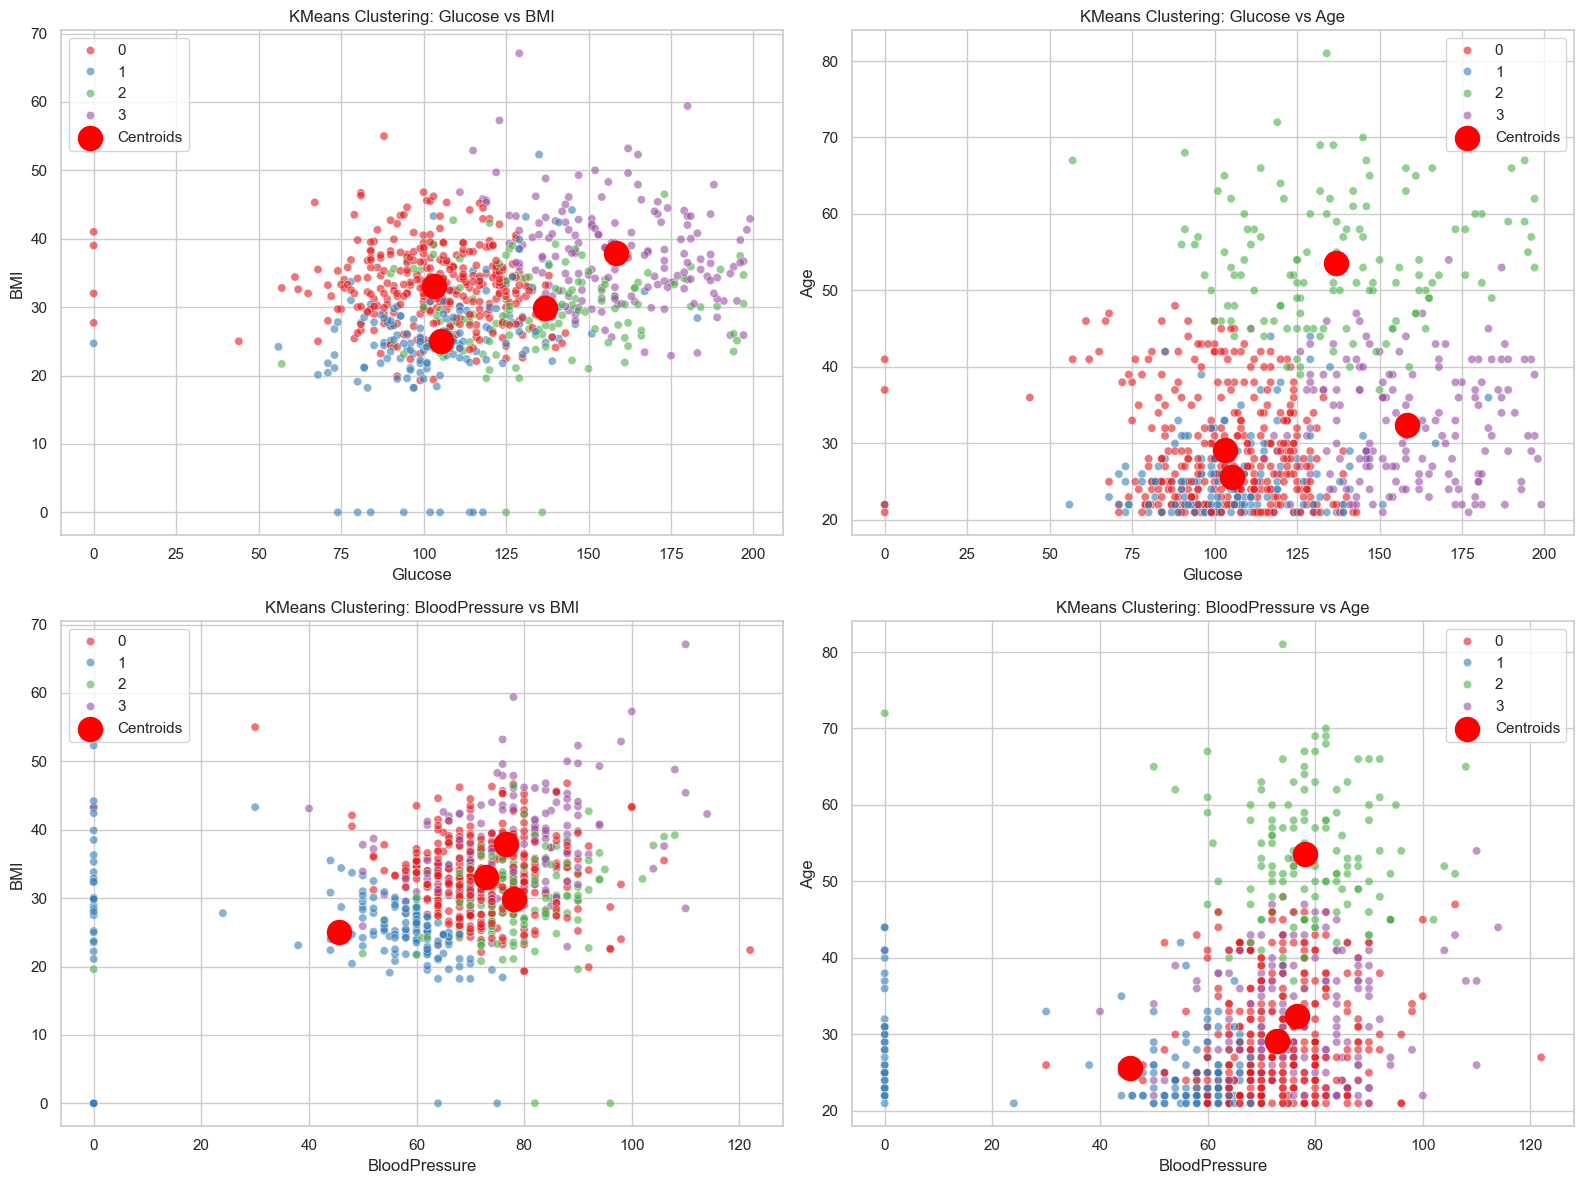

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Масштабирование данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cleaned[['Glucose', 'BMI', 'BloodPressure', 'Age']])

# Обучение K-Means
random_state = 17
kmeans = KMeans(n_clusters=4, random_state=random_state)
labels = kmeans.fit_predict(data_scaled)
centers = kmeans.cluster_centers_

# Обратная стандартизация центров кластеров
centers = scaler.inverse_transform(centers)
print("Центры кластеров:\n", centers)

# Визуализация кластеризации
plt.figure(figsize=(16, 12))

# Взаимосвязь Glucose и BMI
plt.subplot(2, 2, 1)
sns.scatterplot(x=df_cleaned['Glucose'], y=df_cleaned['BMI'], hue=labels, palette='Set1', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: Glucose vs BMI')
plt.legend()

# Взаимосвязь Glucose и Age
plt.subplot(2, 2, 2)
sns.scatterplot(x=df_cleaned['Glucose'], y=df_cleaned['Age'], hue=labels, palette='Set1', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 3], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: Glucose vs Age')
plt.legend()

# Взаимосвязь BloodPressure и BMI
plt.subplot(2, 2, 3)
sns.scatterplot(x=df_cleaned['BloodPressure'], y=df_cleaned['BMI'], hue=labels, palette='Set1', alpha=0.6)
plt.scatter(centers[:, 2], centers[:, 1], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: BloodPressure vs BMI')
plt.legend()

# Взаимосвязь BloodPressure и Age
plt.subplot(2, 2, 4)
sns.scatterplot(x=df_cleaned['BloodPressure'], y=df_cleaned['Age'], hue=labels, palette='Set1', alpha=0.6)
plt.scatter(centers[:, 2], centers[:, 3], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: BloodPressure vs Age')
plt.legend()

plt.tight_layout()
plt.show()


#### PCA для визуализации сокращенной размерности

PCA (Principal Component Analysis) — метод сокращения размерности, используемый для преобразования высокоразмерных данных в пространство с меньшим количеством измерений, сохраняя при этом как можно больше информации (дисперсии) из исходных данных.

В контексте графиков для визуализации результатов кластеризации, PCA используется для проекции многомерных данных в двумерное пространство, чтобы можно было легко визуализировать кластеры.

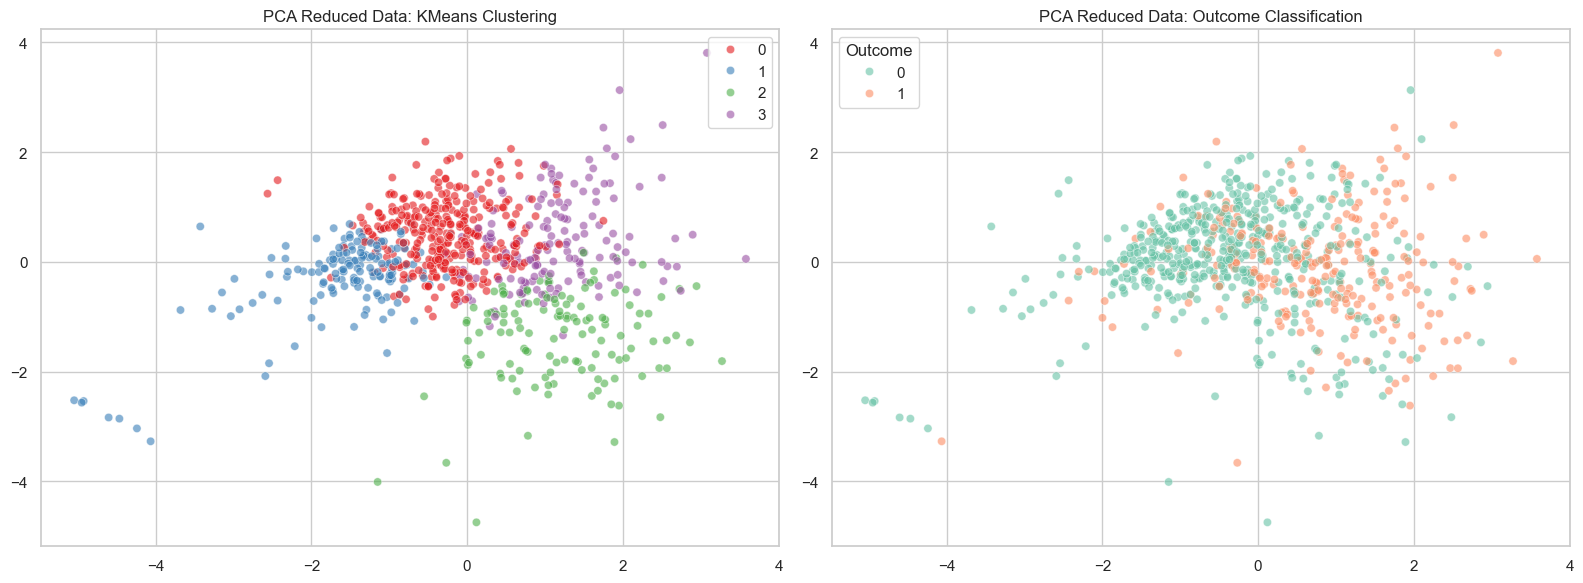

In [9]:
from sklearn.decomposition import PCA

# Снижение размерности с использованием PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled)

# Визуализация сокращенных данных
plt.figure(figsize=(16, 6))

# Визуализация для KMeans кластеризации
plt.subplot(1, 2, 1)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='Set1', alpha=0.6)
plt.title('PCA Reduced Data: KMeans Clustering')

# Визуализация для исходных данных с категорией Outcome
plt.subplot(1, 2, 2)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df_cleaned['Outcome'], palette='Set2', alpha=0.6)
plt.title('PCA Reduced Data: Outcome Classification')

plt.tight_layout()
plt.show()


#### Анализ инерции для метода локтя (метод оценки суммы квадратов расстояний)

Анализ инерции для метода локтя — это техника, используемая для определения оптимального числа кластеров в задаче кластеризации (например, для алгоритма K-Means). Метод основывается на оценке суммы квадратичных отклонений (или инерции) объектов от центров их кластеров.

Инерция (в контексте кластеризации) — это метрика, которая измеряет "плотность" кластеров, то есть, насколько близко точки внутри каждого кластера расположены к его центроиду.
Формально инерция определяется как сумма квадратов расстояний всех точек до ближайшего центра кластера.

Метод локтя:
1. Для различных значений 𝑘 (количества кластеров) вычисляется инерция.
2. Значения инерции отображаются на графике в зависимости от 𝑘.
3. Смотрится точка, после которой уменьшение инерции значительно замедляется. Эта точка называется локтем, и соответствующее значение 𝑘 считается оптимальным числом кластеров.

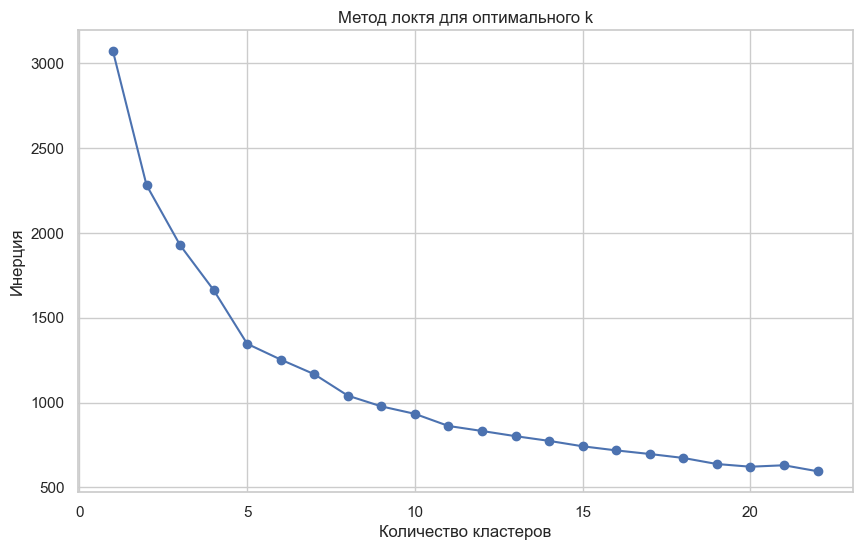

In [10]:
inertias = []
clusters_range = range(1, 23)
for i in clusters_range:
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertias, marker='o')
plt.title('Метод локтя для оптимального k')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

Можно заметить, что после 19-го кластера функция начинает принимать линейный вид, что говорит о следующем: создание более 19-го кластера - не самое оптимальное решение, дальнейшее разбиение данных становится избыточным. 

Расчитаем коэффициенты силуэта

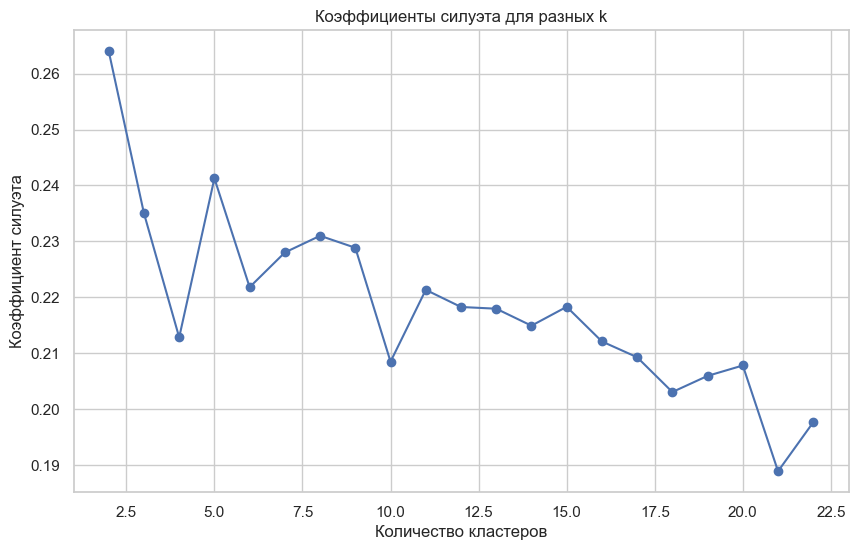

In [11]:
silhouette_scores = []
for i in clusters_range[1:]:  
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

# Построение диаграммы значений силуэта
plt.figure(figsize=(10, 6))
plt.plot(clusters_range[1:], silhouette_scores, marker='o')
plt.title('Коэффициенты силуэта для разных k')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

Средний коэффициент силуэта (silhouette score) используется для оценки качества кластеризации. Его значение лежит в диапазоне от -1 до 1. Что означают различные значения:

* Близко к 1.0 (0.7–1.0): Кластеры хорошо разделены и компактны. Это отличный результат кластеризации.
* От 0.5 до 0.7: Кластеры четко различимы, но есть некоторое пересечение между ними. Это хороший результат.
* От 0.25 до 0.5: Кластеры перекрываются, что указывает на менее четкую границу между группами. Качество кластеризации удовлетворительное, но может потребоваться уточнение числа кластеров или доработка данных.
* Близко к 0.0: Кластеры сильно перекрываются или распределение данных не позволяет выделить четкие группы. В этом случае нужно пересмотреть выбор числа кластеров, алгоритм или исходные данные.
* Меньше 0.0: Плохая кластеризация: точки ближе к центрам чужих кластеров, чем к своим. Это сигнал о том, что данные плохо структурированы для текущей кластеризации.

Средний коэффициент силуэта: 0.213


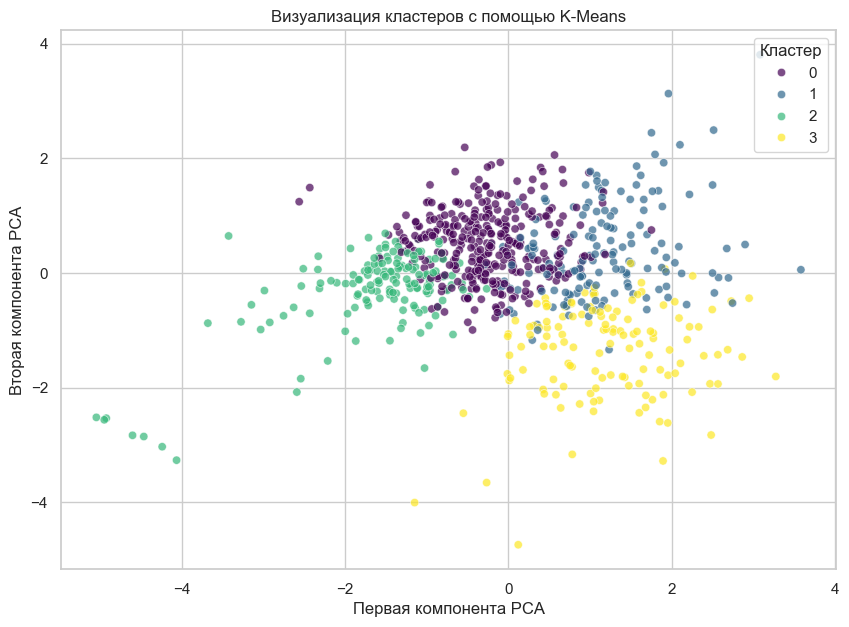

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# ========================
# Масштабирование данных
# ========================
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cleaned[['Glucose', 'BMI', 'BloodPressure', 'Age']])

# ========================
# Применение K-Means
# ========================
kmeans = KMeans(n_clusters=4, random_state=42)  
df_clusters = kmeans.fit_predict(data_scaled)

# ========================
# Оценка качества кластеризации
# ========================
silhouette_avg = silhouette_score(data_scaled, df_clusters)
print(f'Средний коэффициент силуэта: {silhouette_avg:.3f}')

# ========================
# Визуализация кластеров
# ========================
pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_clusters, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью K-Means')
plt.xlabel('Первая компонентa PCA')
plt.ylabel('Вторая компонентa PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()


В нашем случае, результат находится ближе к хорошему, но пока что больше соответствует удовлетворительному состоянию. На графике видно, что кластеры имеют некоторую степень пересечения, что приемлемо. Это может указывать на сложность четкого разделения групп пациентов из-за схожести их характеристик (например, уровня глюкозы, индекса массы тела или давления). Однако, кластеризация все же предоставляет полезное разделение для анализа данных и дальнейшей интерпретации